In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
import cv2
import random
from scipy.signal import savgol_filter
import sys
sys.path.append("src")
import sindy_utils as sindy
from datetime import datetime
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

# autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__() 
        self.encode = nn.Sequential(
            # encoder: N, 3, 404, 720
            nn.Conv2d(3, 16, 2), # N, 16, 403, 719
            nn.ReLU(),
            nn.Conv2d(16, 32, 2), # N, 32, 402, 718
            nn.ReLU(),
            nn.MaxPool2d((2,3), stride=(2,3)), # N, 32, 201, 239              -- pool --
            nn.Conv2d(32, 64, 4), # N, 64, 198, 236
            nn.ReLU(),
            nn.Conv2d(64, 96, 4), # N, 96, 195, 233
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # N, 96, 97, 116                       -- pool --
            nn.Conv2d(96, 128, 5), # N, 128, 93, 112
            nn.ReLU(),
            nn.Conv2d(128, 150, 5, stride=2, padding=1), # N, 150, 46, 55
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2), # N, 150, 23, 27                        -- pool --
            nn.Conv2d(150, 200, 9, stride=2), # N, 200, 8, 10
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(200*8*10,params['z_dim'])
        # Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
        # Input [-1, +1] -> use nn.Tanh    
        
        # note: encoder and decoder are not symmetric
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(200, 150, 4), # N, 150, 11, 13
            nn.ReLU(),
            nn.ConvTranspose2d(150, 128, 5, stride=(2,3), padding=(2,2), output_padding=(0,2)), # N, 128, 21, 39
            nn.ReLU(),
            nn.ConvTranspose2d(128, 96, 4, stride=2, padding=(1,0)), # N, 96, 42, 80
            nn.ReLU(),
            nn.ConvTranspose2d(96, 64, 8), # N, 64, 49, 87
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 8, stride=2, padding=(2,1), output_padding=(0,1)), # N, 32, 100, 179
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 5, stride=2, padding=1), # N, 16, 201, 359
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 5, stride=2, padding=1, output_padding=(1,1)), # N, 3, 404, 720
            nn.ReLU()
        )   
        
        self.fc2 = nn.Linear(params['z_dim'], 200*8*10)

    def forward(self, x, z, mode):
        '''
        x: input for encoder
        z: input for decoder
        mode: 
            'train' -> use encoded for decoder
            'test'  -> feed z in an get decoded
        
        '''
        if mode == 'train':
            encoded = self.encode(x)
            encoded = encoded.view(-1,200*8*10)
            encoded = self.fc1(encoded)

            decoded = self.fc2(encoded)
            decoded = decoded.view(-1,200,8,10)
            decoded = self.decode(decoded)
        else:
            encoded = torch.zeros(1)

            decoded = self.fc2(z)
            decoded = decoded.view(-1,200,8,10)
            decoded = self.decode(decoded)
        
        return encoded, decoded

    
def calculateSindy(z, Xi, poly_order, include_sine_param):
    z_new = z.detach().numpy()
    
    theta = torch.from_numpy(sindy.sindy_library(z_new, poly_order, include_sine=include_sine_param))
    
    dz_prediction = torch.matmul(theta, Xi).float()
    
    return dz_prediction

def matrixToNorm(x, offset=0, factor=0.95):
    x = (x - x.min() + offset) / x.max() * factor
    return x

def constructXi(data, zDim):
    '''
    input: data as a list with shape [len batch_size RGB hight width]
    return: Xi for oneVideo training
    
    '''
    # processs the data
    z_tensor = torch.empty((0, zDim))
    data_len = len(data)
    print('length of entire data', data_len)
    for i in range(data_len):
        if i == 20:
            break
        z_tensor_tmp, _ = autoencoder(train_data[i], 0, mode='train')
        z_tensor = torch.cat((z_tensor, z_tensor_tmp), 0)
        if i % 10 == 0:
            print(i, z_tensor.shape)
        del z_tensor_tmp
    
    dz_tensor = z_tensor[2:data_len]
    z_tensor = z_tensor[1:data_len-1]
    
    # calculate sindy and Xi for the data
    z_tensor = z_tensor.cpu().detach().numpy()
    dz_tensor = dz_tensor.cpu().detach().numpy()

    Theta = torch.from_numpy(sindy.sindy_library(z_tensor, poly_order, include_sine=include_sine_param))
    Xi = torch.from_numpy(sindy.sindy_fit(Theta, dz_tensor, threshold_sindy))
    del Theta
    del z_tensor
    del dz_tensor
    
    return Xi

2022-01-14 10:12:57


### Data and model loading and configurations

In [2]:
############################## configurations #####################################
poly_order = 4
include_sine_param = False
threshold_sindy = 0.05

# paths
path_folder = 'results/v5_6_hyperparam_Ae/'
which_ae = 'Ae_1500epoch_bs16_lr1e-05_z1_sindt05_poly4.pt'
which_Xi = 'Xi1500epoch_lr1e-05_z1_sindt05_poly4.pt'
saveFig = 'figures/v5_6_hyperparam_Ae/'

In [3]:
to_load = path_folder + which_ae
lr_rate = [1e-05, 0.0001]
z_dim = [1,2,3,4,5,10]
ae_list = []
for lr in lr_rate:
    for z in z_dim:
        to_load = path_folder+'Ae_1500epoch_bs16_lr' + str(lr) +'_z'+ str(z) +'_sindt05_poly4.pt'
        ae_list.append(torch.load(to_load).cpu())
print('autoencoder', len(ae_list))

# load a train data
path_folder_data = path_folder+'data/'
if os.path.isfile(path_folder_data + 'train_data.pt'):
    train_data = torch.load(path_folder_data + 'train_data.pt')
    print('train data: ', len(train_data), len(train_data[0]), len(train_data[0][0]), len(train_data[0][0][0]), len(train_data[0][0][0][0]))
    print('train data reading done!')

if os.path.isfile(path_folder_data + 'validation_data.pt'):
    # load a validation data
    validation_data = torch.load(path_folder_data + 'validation_data.pt')
    print('validation data: ', len(validation_data), len(validation_data[0]), len(validation_data[0][0]), len(validation_data[0][0][0]), len(validation_data[0][0][0][0]))
    print('validation data reading done!')

if os.path.isfile(path_folder_data + 'test_data.pt'):
    # loading test data
    test_data = torch.load(path_folder_data + 'test_data.pt')
    print('test data: ', len(test_data), len(test_data[0]), len(test_data[0][0]), len(test_data[0][0][0]), len(test_data[0][0][0][0]))
    print('test data reading done!')
else:
    print('No data to read')

# load Xi
if os.path.isfile(path_folder + which_Xi):
    Xi = torch.load(path_folder + which_Xi)
    print('Xi loaded succesfully!')
    print(Xi)
else:
    print('No Xi to load')

autoencoder 12
train data:  30 16 3 404 720
train data reading done!
validation data:  4 16 3 404 720
validation data reading done!
test data:  4 16 3 404 720
test data reading done!
No Xi to load


### plotting images of autoencoder

random examples
lr 1e-05 z dimension 1
0
max recon_data 0.9171108


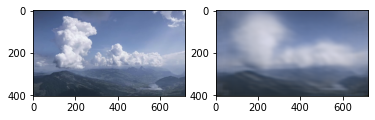

lr 1e-05 z dimension 2
1
max recon_data 0.9309314


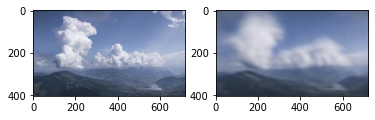

lr 1e-05 z dimension 3
2
max recon_data 0.95011955


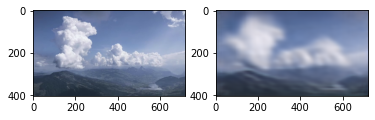

lr 1e-05 z dimension 4
3
max recon_data 0.9705177


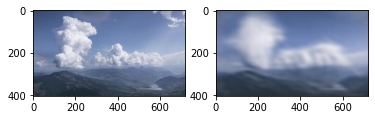

lr 1e-05 z dimension 5
4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


max recon_data 1.0324302


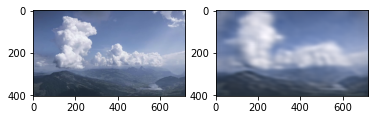

lr 1e-05 z dimension 10
5
max recon_data 0.92648005


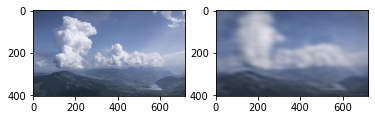

lr 0.0001 z dimension 1
6
max recon_data 1.0184826


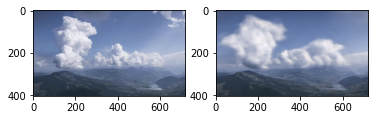

lr 0.0001 z dimension 2
7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


max recon_data 1.0393989


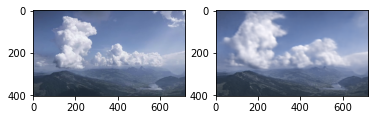

lr 0.0001 z dimension 3
8
max recon_data 1.0144689


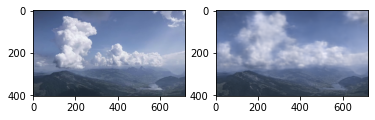

lr 0.0001 z dimension 4
9
max recon_data 0.95228434


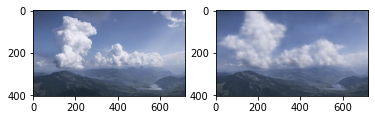

lr 0.0001 z dimension 5
10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


max recon_data 1.0288401


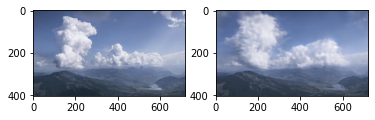

lr 0.0001 z dimension 10
11
max recon_data 0.0


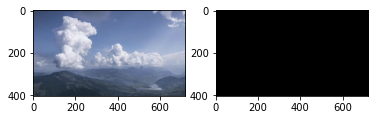

In [4]:
whichData = 'validation_data'      # 1: train_data, 2: validation_data, 3: test_data
if whichData == 'train_data':
    data = train_data
elif whichData == 'validation_data':
    data = validation_data
else:
    data = test_data

# compare auto encoder results of different hyperparameters
print('random examples')
randPlace = random.randint(0, len(data)-1)

for lr_i, lr in enumerate(lr_rate):
    for z_i, z in enumerate(z_dim):
        print('lr',lr,'z dimension',z)
        print(lr_i*len(z_dim) + z_i)
        autoencoder = ae_list[lr_i*len(z_dim) + z_i]
        z_tensor, recon_tensor = autoencoder(data[randPlace], 0, mode='train')
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(data[randPlace][0].permute(1,2,0).detach().numpy())
        plt.subplot(1,2,2)
        print('max recon_data', recon_tensor.cpu().detach().numpy().max())
        plt.imshow(recon_tensor[0].permute(1,2,0).detach().numpy())
        plt.savefig(saveFig + 'autoencoder1500Result_lr'+str(lr)+'_z'+str(z)+'_'+whichData+'.png')
        plt.show()


### calculate Xi if its not in the data

In [ ]:
# Xi for every hyperparameter 
xi_list = []
for lr_i,lr in enumerate(lr_rate):
    for z_i,z in enumerate(z_dim):
        autoencoder = ae_list[lr_i*len(z_dim) + z_i]
        Xi = constructXi(train_data, zDim=z)
        torch.save(Xi, path_folder + 'Xi1500epoch_lr'+str(lr)+'_z'+str(z)+'.pt')
        xi_list.append(Xi)
print('Xi list done!', len(xi_list))

In [6]:
# load Xi
xi_list = []
for lr in lr_rate:
    for z in z_dim:
        to_load = path_folder+'Xi1500epoch_lr' + str(lr) +'_z'+ str(z) +'.pt'
        xi = torch.load(to_load).cpu()
        xi_list.append(xi)
        print('Xi of dimension z',z,'lr',lr,'is:', xi)


Xi of dimension z 1 lr 1e-05 is: tensor([[-11164.4836],
        [-35678.7567],
        [-42748.6033],
        [-22757.6049],
        [ -4542.0409]], dtype=torch.float64)
Xi of dimension z 2 lr 1e-05 is: tensor([[ 6.6450e+04, -1.5593e+04],
        [-7.4783e+04, -2.7880e+04],
        [-2.3502e+04,  2.9201e+04],
        [ 4.1890e+04,  5.0313e+04],
        [ 1.0277e+04, -2.0570e+04],
        [ 3.6538e+03, -7.6247e+03],
        [-1.7065e+04, -2.4940e+04],
        [ 2.7928e+03,  3.8884e+03],
        [-1.5062e+03,  4.2986e+03],
        [-1.1313e+02,  7.4838e+02],
        [ 2.6917e+03,  2.9442e+03],
        [-2.1575e+02,  1.8074e+03],
        [-5.7854e+02, -1.6264e+03],
        [ 1.7176e+02,  2.5617e+01],
        [-2.0200e+01, -4.7940e+01]], dtype=torch.float64)
Xi of dimension z 3 lr 1e-05 is: tensor([[ -8453.7584,  29469.4965, -16843.1183],
        [  8358.9777,  15909.7131, -25715.1908],
        [  -283.5505, -17983.1869,  14829.4739],
        [  5969.4264, -18503.3206,  14060.7289],
      

### plotting in z dimension

0
5
z_true dimension (160, 1)
graph(s) for z_true


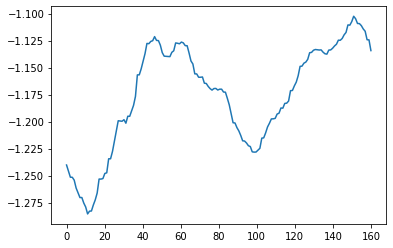

graph(s) for z_sindy prediction
0
5
z_true dimension (160, 2)
graph(s) for z_true


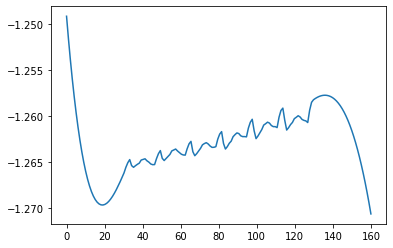

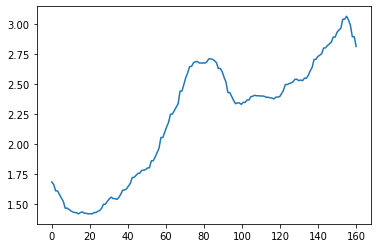

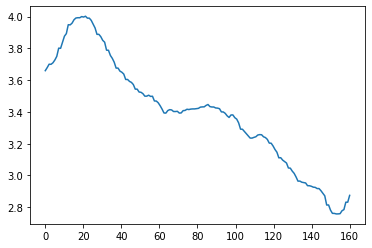

graph(s) for z_sindy prediction
0
5
z_true dimension (160, 3)
graph(s) for z_true


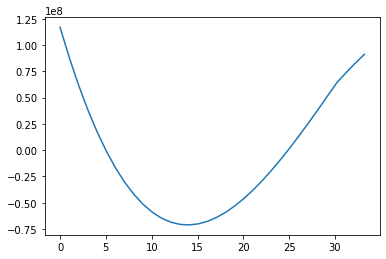

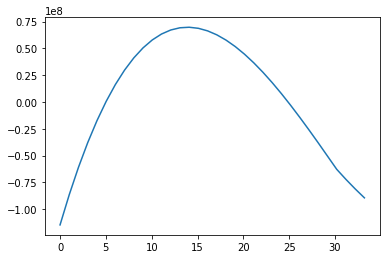

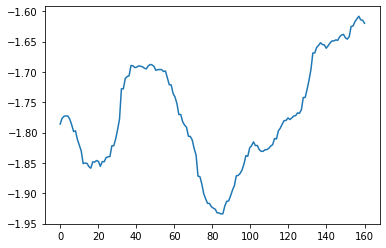

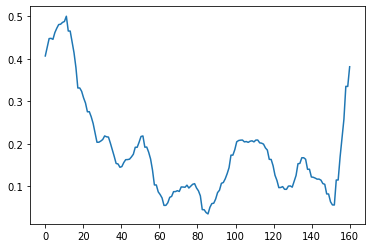

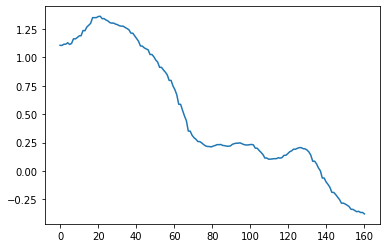

graph(s) for z_sindy prediction
0
5
z_true dimension (160, 4)
graph(s) for z_true


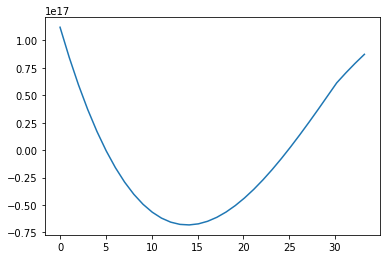

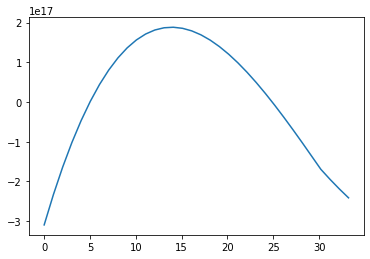

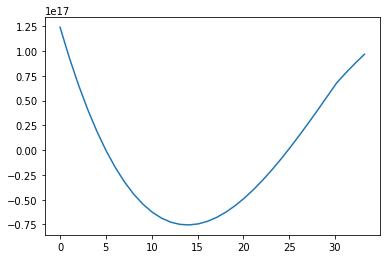

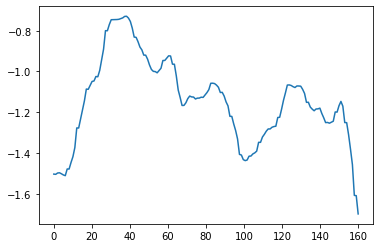

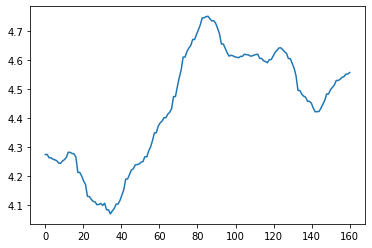

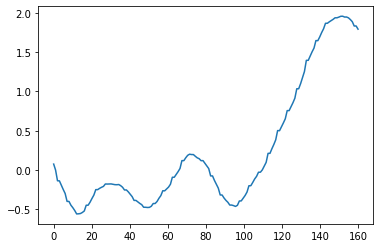

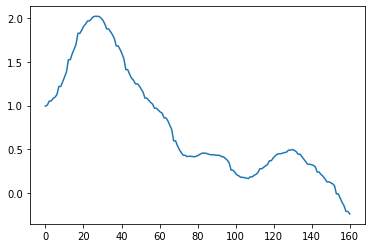

graph(s) for z_sindy prediction
0
5
z_true dimension (160, 5)
graph(s) for z_true


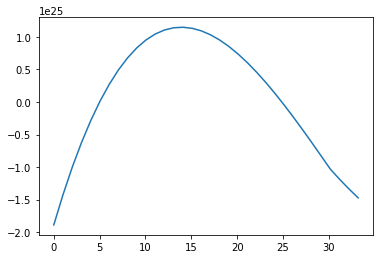

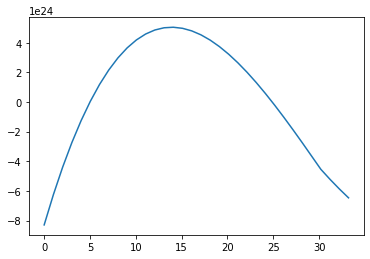

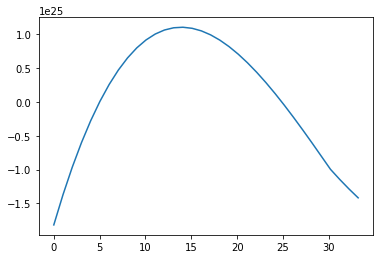

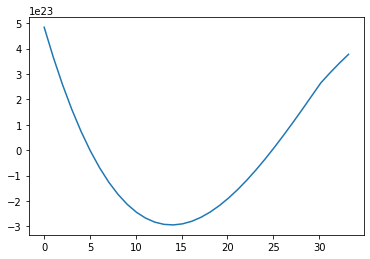

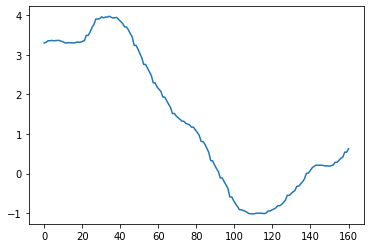

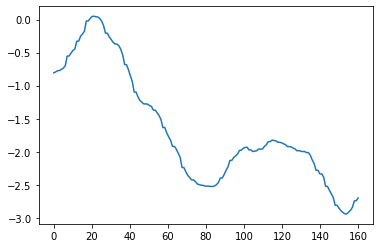

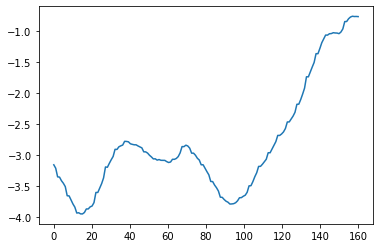

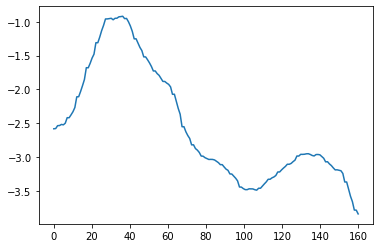

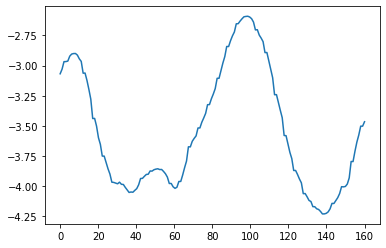

graph(s) for z_sindy prediction
0
5
z_true dimension (160, 10)
graph(s) for z_true


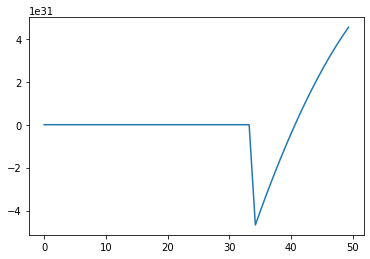

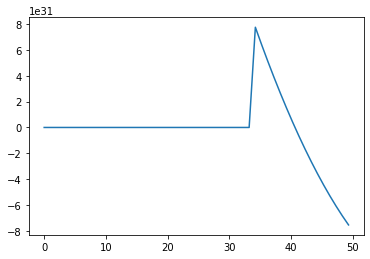

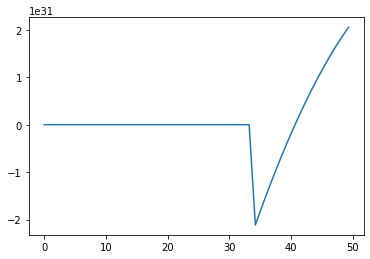

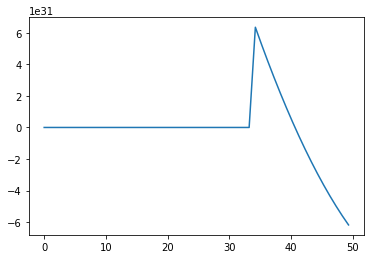

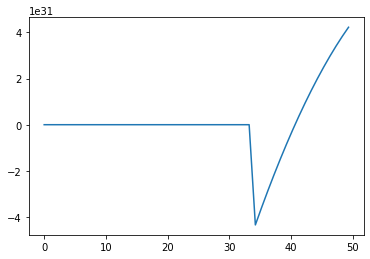

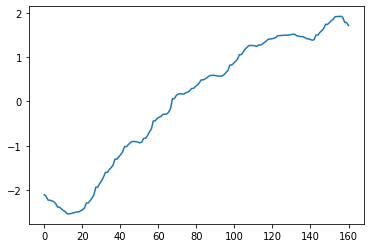

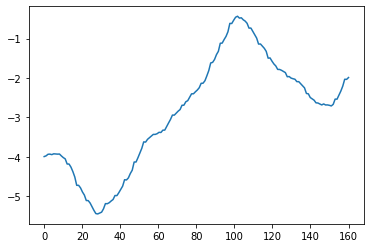

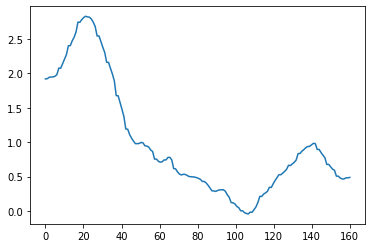

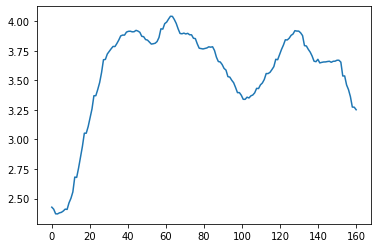

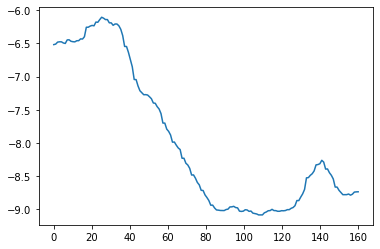

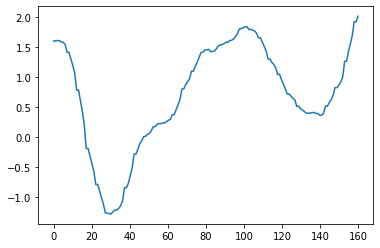

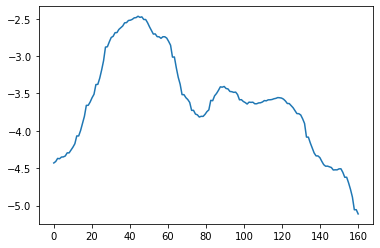

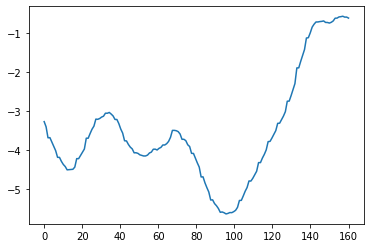

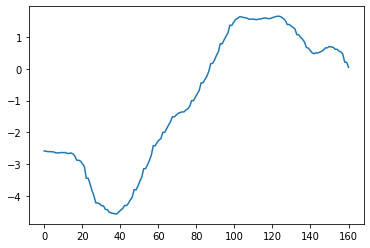

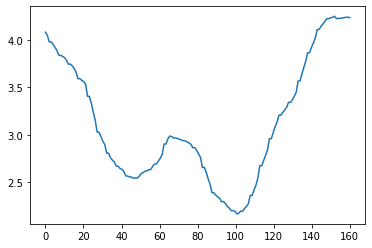

graph(s) for z_sindy prediction
0
5
z_true dimension (160, 1)
graph(s) for z_true


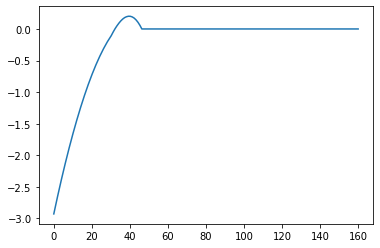

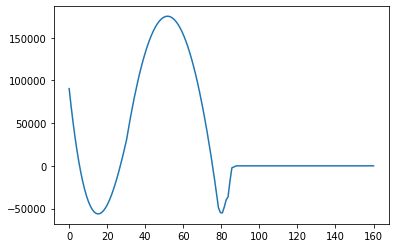

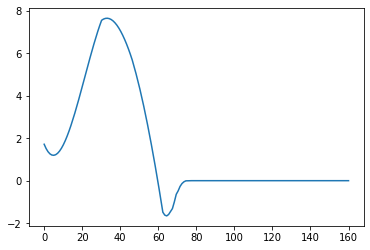

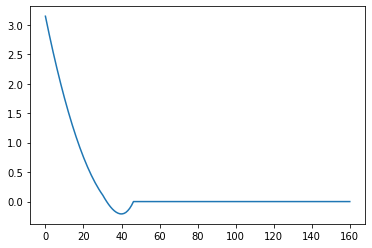

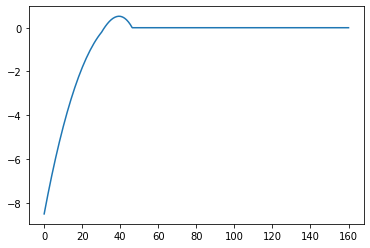

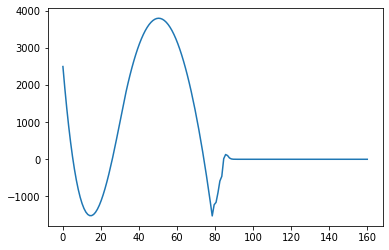

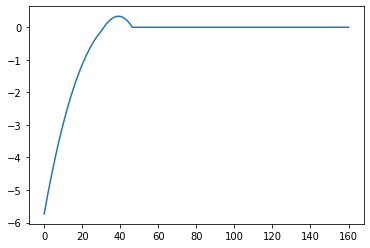

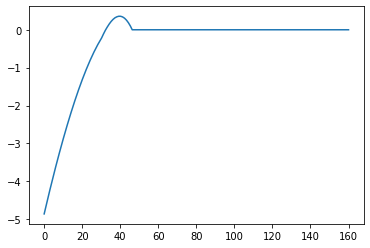

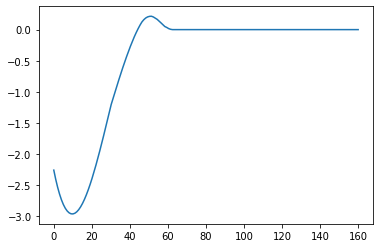

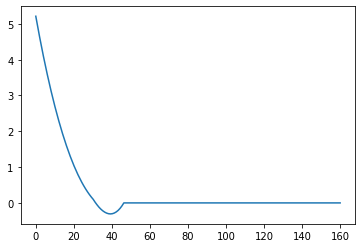

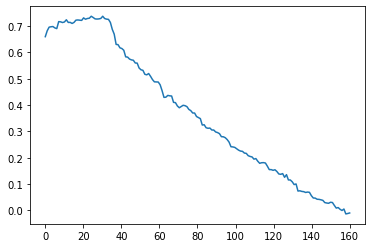

graph(s) for z_sindy prediction
0
5
z_true dimension (160, 2)
graph(s) for z_true


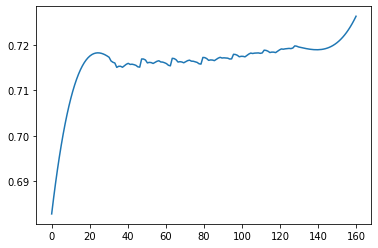

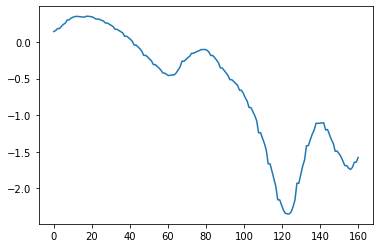

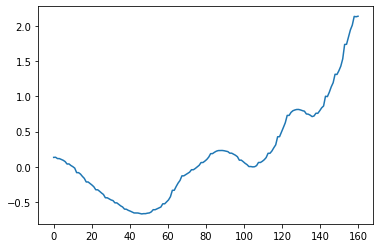

graph(s) for z_sindy prediction
0
5
z_true dimension (160, 3)
graph(s) for z_true


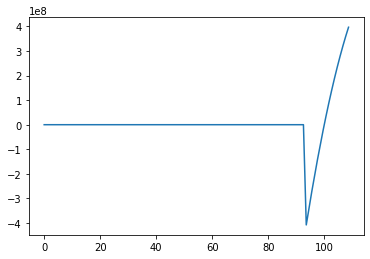

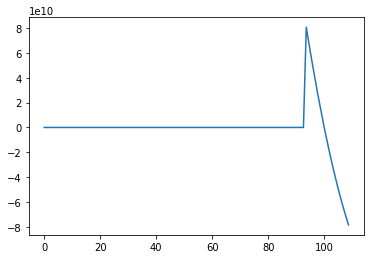

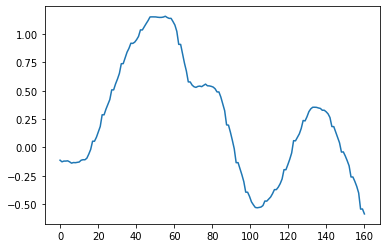

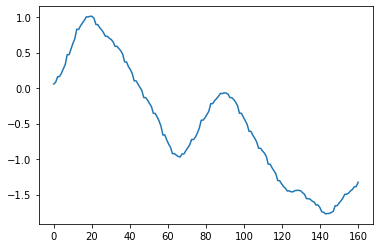

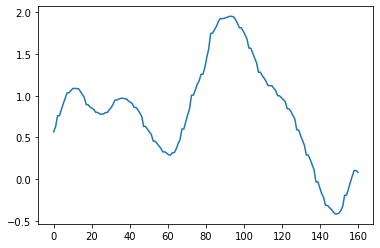

graph(s) for z_sindy prediction
0
5
z_true dimension (160, 4)
graph(s) for z_true


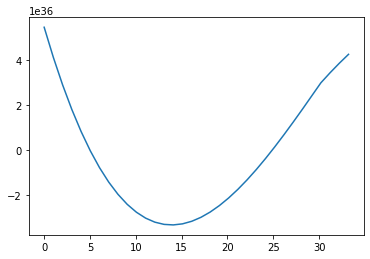

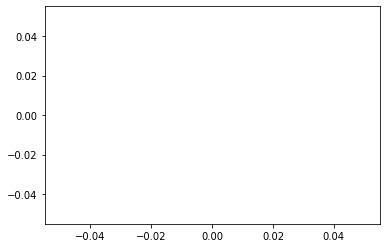

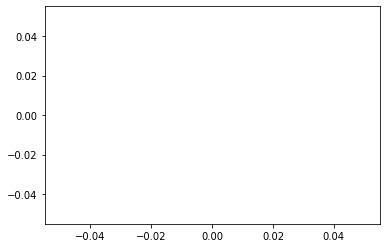

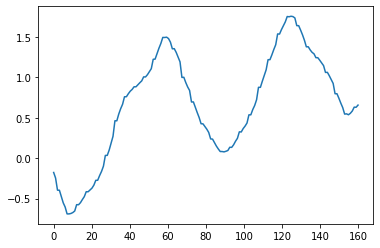

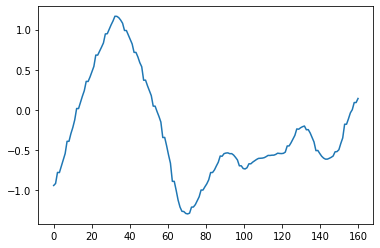

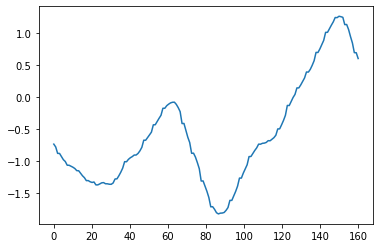

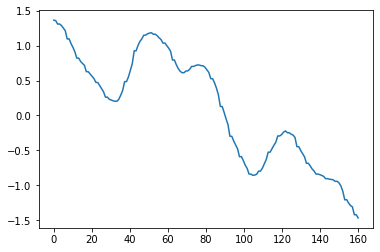

graph(s) for z_sindy prediction
0
5
z_true dimension (160, 5)
graph(s) for z_true


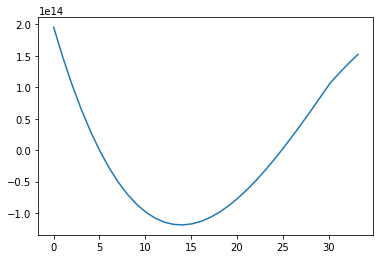

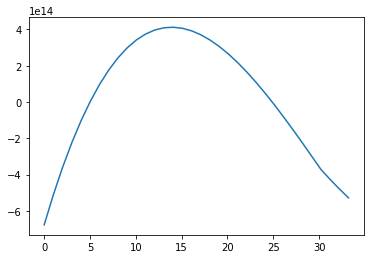

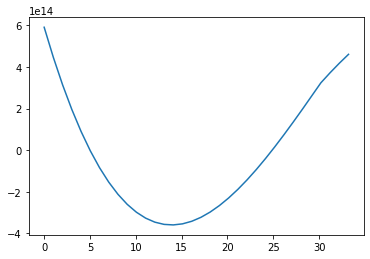

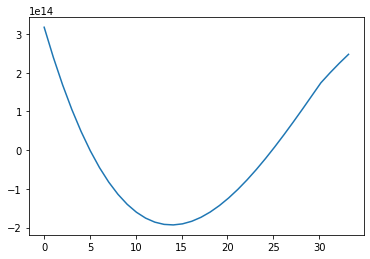

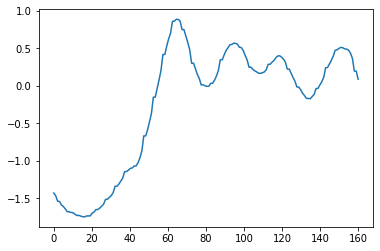

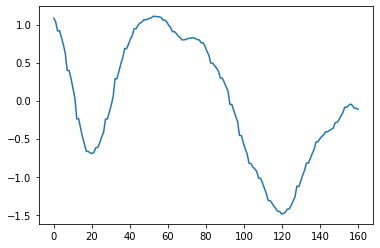

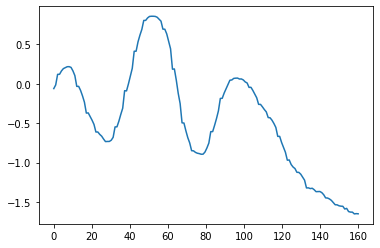

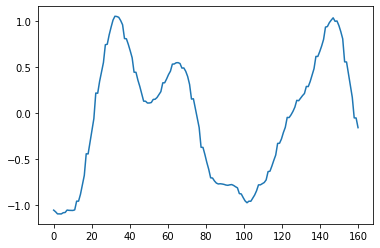

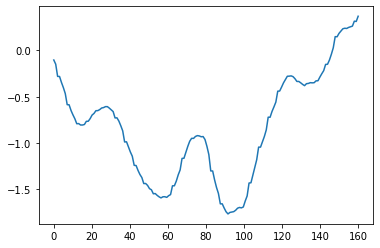

graph(s) for z_sindy prediction
0
5
z_true dimension (160, 10)
graph(s) for z_true


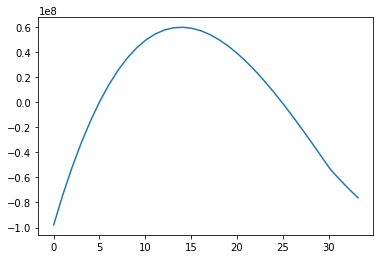

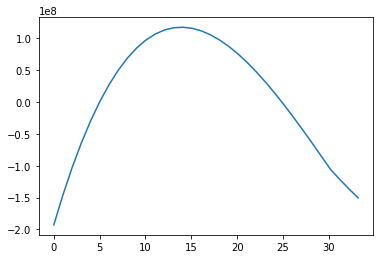

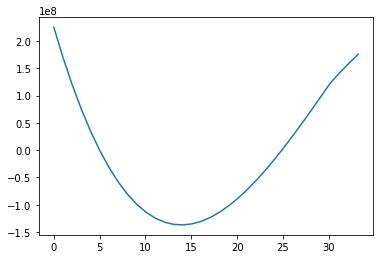

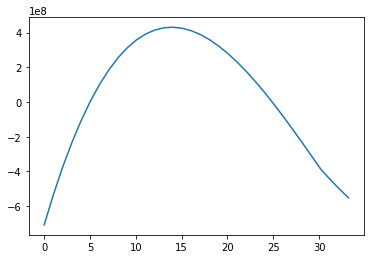

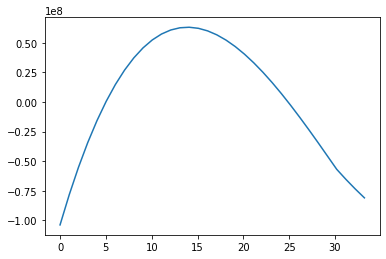

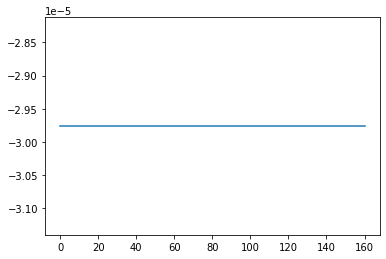

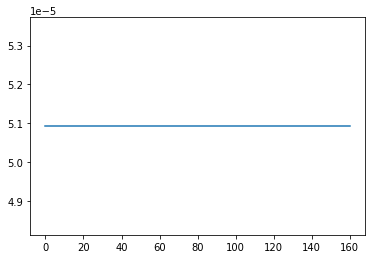

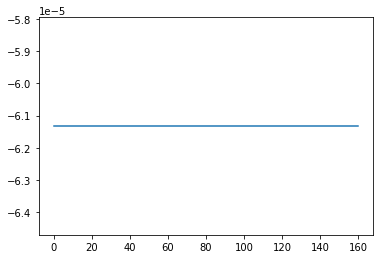

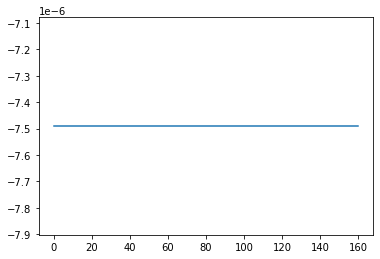

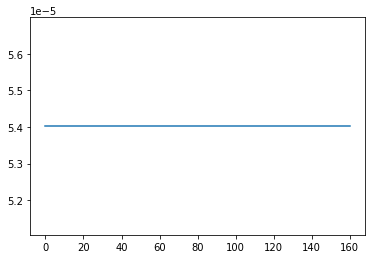

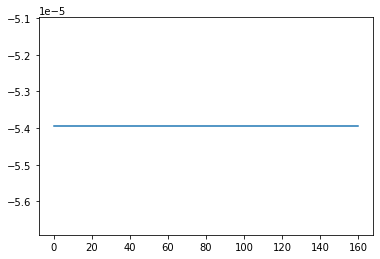

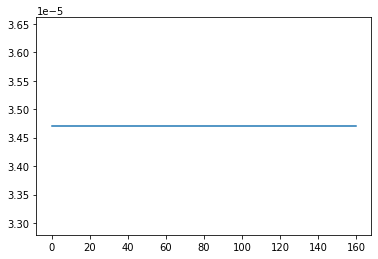

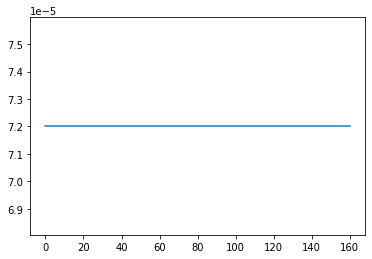

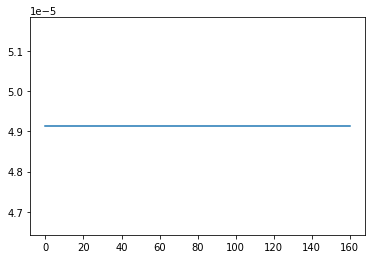

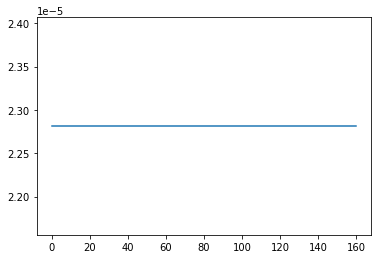

graph(s) for z_sindy prediction


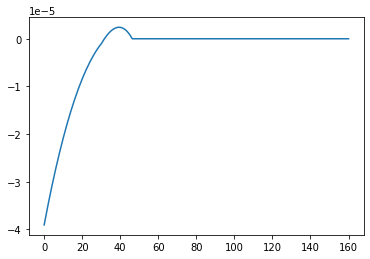

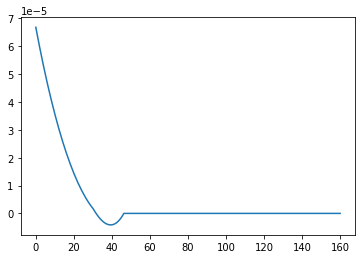

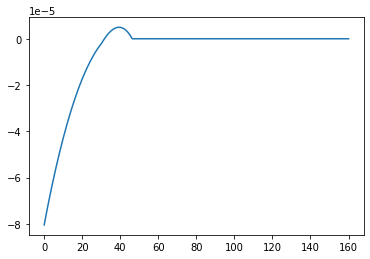

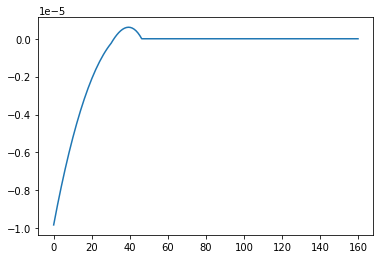

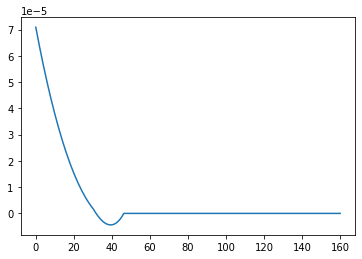

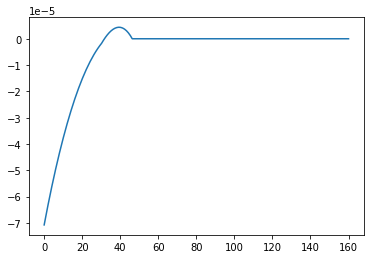

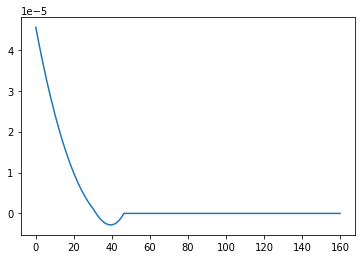

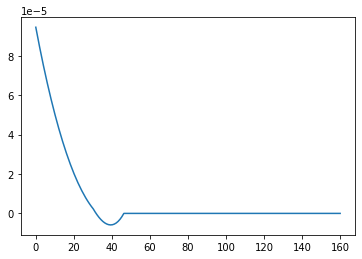

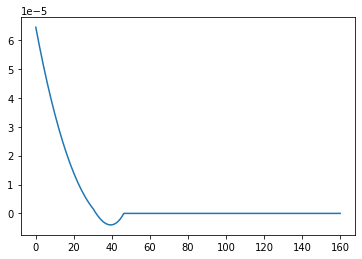

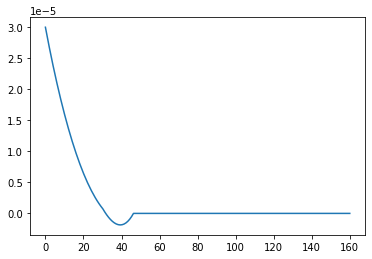

In [11]:
whichData = 1      # 1: train_data, 2: validation_data, 3: test_data
if whichData == 1:
    data = train_data
elif whichData == 2:
    data = validation_data
else:
    data = test_data
    
ChooseLength = 10  # len(data)
batch_size = 16

def plotZDim(zDim, lr_rate):
    # compute true z
    z_true = np.empty((ChooseLength*batch_size, zDim))
    for index in range(0, ChooseLength):
        if index >= len(data):
            break
        z_tensor, recon_tensor = autoencoder(data[index], 0, mode='train')
        z_true[index*batch_size:(index+1)*batch_size][:] = z_tensor.cpu().detach().numpy()
        if index % 5 == 0: print(index)

    print('z_true dimension', z_true.shape)

    # print graph(s) for z_true
    print('graph(s) for z_true')
    for graph in range(z_true.shape[1]):
        plt.figure()
        x = np.linspace(0, z_true.shape[0], z_true.shape[0])
        y = z_true[:,graph]
        plt.plot(x, y)
        plt.savefig(saveFig + 'graph_lr'+str(lr_rate)+'_z'+str(zDim)+'True_train' +str(graph)+ '.png')
    plt.show()

    # compute sindy z predition based on first one
    z_tensor_first, recon_tensor_first = autoencoder(data[0], 0, mode='train')
    z = z_tensor_first.cpu().detach().numpy()
    z_sindy = np.empty((ChooseLength*batch_size, zDim))
    z_sindy[0:16] = z
    for index_s in range(0, ChooseLength-1):
        Theta = torch.from_numpy(sindy.sindy_library(z, poly_order, include_sine=include_sine_param))
        dz_predict = torch.matmul(Theta, Xi).float()
        z_sindy[(index_s+1)*batch_size:(index_s+2)*batch_size] = dz_predict.cpu().detach().numpy()
        z = dz_predict


    # print graph(s) for z_sindy
    print('graph(s) for z_sindy prediction')
    for graph in range(z_sindy.shape[1]):
        plt.figure()
        x = np.linspace(0, z_sindy.shape[0], z_sindy.shape[0])
        z_sindy[:,graph] = savgol_filter(z_sindy[:,graph], 61, 3)
        y = z_sindy[:,graph]
        #y_smooth = savgol_filter(y, 61, 3) # window size 51, polynomial order 3
        plt.plot(x, y)
        #plt.plot(x, y_smooth, color='red')
        plt.savefig(saveFig + 'graph_lr'+str(lr_rate)+'_z'+str(zDim)+'Sindy_train' +str(graph)+ '.png')
    plt.show()
        
for lr_i,lr in enumerate(lr_rate):
    for z_i,z in enumerate(z_dim):
        autoencoder = ae_list[lr_i*len(z_dim) + z_i]
        Xi = xi_list[lr_i*len(z_dim) + z_i]
        plotZDim(z, lr)

### Producing a video with sindy steps

In [ ]:
until = 10

# test model
def test(data):
    video_reconstruction = []
    # predict videos
    # first step encode first batch
    img = data[0]
    encode_tensor, recon_tensor = autoencoder(img, 0, mode='train')
    
    # predict the future using only sindy model, new video starts always at position vid_nbr * until
    for i in range(0, until):
        if i % 5 == 0: print('pred', i)
        video_reconstruction.append(recon_tensor)
        dz_tensor = calculateSindy(encode_tensor, Xi, poly_order, include_sine_param)
        _, recon_tensor = autoencoder(0, dz_tensor, mode='test')
        encode_tensor = dz_tensor
            
    return video_reconstruction


video_output = test(test_data)
print('prediction done!')

#del test_data

In [ ]:
# test with z_sindy from above
batch_size = 16

# test model with filtered z coordinates
def test(zData):
    video_reconstruction = []
    # predict videos
    for i in range(int(len(zData)/batch_size)):
        print(i)
        z_tensor = torch.from_numpy(zData[i*batch_size:(i+1)*batch_size,:])
        _, recon_tensor = autoencoder(0, z_tensor.float(), mode='test')
        video_reconstruction.append(recon_tensor)        
            
    return video_reconstruction


video_output = test(z_sindy)
print('prediction done!')

#del test_data

In [ ]:
# make videos
frame_width = len(video_output[0][0][0][0])
frame_height = len(video_output[0][0][0])
fps = 25.0
video_output = video_output
#fourcc = cv2.VideoWriter_fourcc('I','4','2','0')
#fourcc = cv2.VideoWriter_fourcc('P','I','M','1')
#fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
fourcc = cv2.VideoWriter_fourcc('D','I','V','3')
#fourcc = cv2.VideoWriter_fourcc('F','L','V','1')
# write different videos
#fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
#fourcc = cv2.VideoWriter_fourcc('D','I','V','3')
#fourcc = cv2.VideoWriter_fourcc('F','M','P','4')
out1 = cv2.VideoWriter(saveFig +'videoSindyPrediction.avi', fourcc, fps, (frame_width,frame_height))
#out2 = cv2.VideoWriter('video2.mov',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))


print('output video', len(video_output), len(video_output[0]), len(video_output[0][0]), len(video_output[0][0][0]), len(video_output[0][0][0][0]))

# undo batch structure
videoProcessing = []
count = -1
for img in range(0, len(video_output)*len(video_output[0])):
    imgIn_batch = img % batch_size
    # new batch
    if imgIn_batch == 0:
        count += 1
    img_toAppend = video_output[count][imgIn_batch]
    videoProcessing.append(img_toAppend)
        
#del video_output
print('video currently procession', len(videoProcessing), len(videoProcessing[0]), len(videoProcessing[0][0]), len(videoProcessing[0][0][0]))
    
for img in range(0,len(videoProcessing)):
    frame_local = np.transpose(videoProcessing[img].detach().numpy(), [1,2,0])
    frame_local = cv2.cvtColor(frame_local, cv2.COLOR_RGB2BGR)
    # print(frame_local) --> seems unstable, not a number and doesn't save it as a video
    out1.write(frame_local.shape)
    # show video
    cv2.imshow('Frame',frame_local)

    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q') and img >= 10:
        break
    
    # Press w on keyboard to wait
    if cv2.waitKey(25) & 0xFF == ord('w'):
        while(True):
            if cv2.waitKey(25) & 0xFF == ord('e'):
                break
            

# When everything done, release the video capture and video write objects
out1.release()

# Closes all the frames
cv2.destroyAllWindows()

print('finished prediction video output!')

### questions
- Do I have that Xi regresses to the next state, now it is kind of a loop?